### imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn.modules.loss import MSELoss
from tqdm import trange, tqdm #
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from core.utils.plot_utils import saveallforms
from core.gaussian_mixture_lib import GaussianMixture, GaussianMixture_torch
from sklearn.cluster import KMeans, MiniBatchKMeans
from torchvision.utils import save_image, make_grid

### Score function and GMM score

In [3]:

def marginal_prob_std(t, sigma):
  """Note that this std -> 0, when t->0
  So it's not numerically stable to sample t=0 in the dataset
  Note an earlier version missed the sqrt...
  """
  return torch.sqrt( (sigma**(2*t) - 1) / 2 / torch.log(torch.tensor(sigma)) ) # sqrt fixed Jun.19


def denoise_loss_fn(model, x, marginal_prob_std_f, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability, sample t uniformly from [eps, 1.0]
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std_f(random_t,)
  perturbed_x = x + z * std[:, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=(1)))
  return loss


def eval_score_td(X_train_tsr, score_model_td,
                   sigma=25,
                   nepochs=20,
                   eps=1E-3,
                   batch_size=None,
                   device="cpu",):
    ndim = X_train_tsr.shape[1]
    score_model_td.to(device)
    X_train_tsr = X_train_tsr.to(device)
    marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)
    pbar = trange(nepochs)
    score_model_td.eval()
    loss_traj = []
    for ep in pbar:
        if batch_size is None:
            with torch.no_grad():
                loss = denoise_loss_fn(score_model_td, X_train_tsr, marginal_prob_std_f, eps=eps)
        else:
            idx = torch.randint(0, X_train_tsr.shape[0], (batch_size,))
            with torch.no_grad():
                loss = denoise_loss_fn(score_model_td, X_train_tsr[idx], marginal_prob_std_f, eps=eps)

        pbar.set_description(f"step {ep} loss {loss.item():.3f}")
        loss_traj.append(loss.item())
    return loss_traj

In [4]:
def gaussian_mixture_score_batch_sigma_torch(x, mus, Us, Lambdas, weights=None):
    """
    Evaluate log probability and score of a Gaussian mixture model in PyTorch
    :param x: [N batch,N dim]
    :param mus: [N comp, N dim]
    :param Us: [N comp, N dim, N dim]
    :param Lambdas: [N batch, N comp, N dim]
    :param weights: [N comp,] or None
    :return:
    """
    if Lambdas.ndim == 2:
        Lambdas = Lambdas[None, :, :]
    ndim = x.shape[-1]
    logdetSigmas = torch.sum(torch.log(Lambdas), dim=-1)  # [N batch, N comp,]
    residuals = (x[:, None, :] - mus[None, :, :])  # [N batch, N comp, N dim]
    rot_residuals = torch.einsum("BCD,CDE->BCE", residuals, Us)  # [N batch, N comp, N dim]
    MHdists = torch.sum(rot_residuals ** 2 / Lambdas, dim=-1)  # [N batch, N comp]
    logprobs = -0.5 * (logdetSigmas + MHdists)  # [N batch, N comp]
    if weights is not None:
        logprobs += torch.log(weights)  # - 0.5 * ndim * torch.log(2 * torch.pi)  # [N batch, N comp]
    participance = F.softmax(logprobs, dim=-1)  # [N batch, N comp]
    compo_score_vecs = torch.einsum("BCD,CED->BCE", - (rot_residuals / Lambdas),
                                    Us)  # [N batch, N comp, N dim]
    score_vecs = torch.einsum("BC,BCE->BE", participance, compo_score_vecs)  # [N batch, N dim]
    return score_vecs


def gaussian_mixture_lowrank_score_batch_sigma_torch(x,
                 mus, Us, Lambdas, sigma, weights=None):
    """
    Evaluate log probability and score of a Gaussian mixture model in PyTorch
    :param x: [N batch,N dim]
    :param mus: [N comp, N dim]
    :param Us: [N comp, N dim, N rank]
    :param Lambdas: [N comp, N rank]
    :param sigma: [N batch,] or []
    :param weights: [N comp,] or None
    :return:
    """
    if Lambdas.ndim == 2:
        Lambdas = Lambdas[None, :, :]
    ndim = x.shape[-1]
    nrank = Us.shape[-1]
    logdetSigmas = torch.sum(torch.log(Lambdas + sigma[:, None, None] ** 2), dim=-1)  # [N batch, N comp,]
    logdetSigmas += (ndim - nrank) * 2 * torch.log(sigma)[:, None]  # [N batch, N comp,]
    residuals = (x[:, None, :] - mus[None, :, :])  # [N batch, N comp, N dim]
    residual_sqnorm = torch.sum(residuals ** 2, dim=-1)  # [N batch, N comp]
    Lambda_tilde = Lambdas / (Lambdas + sigma[:, None, None] ** 2)  # [N batch, N comp, N rank]
    rot_residuals = torch.einsum("BCD,CDE->BCE", residuals, Us)  # [N batch, N comp, N dim]
    MHdists_lowrk = torch.sum(rot_residuals ** 2 * Lambda_tilde, dim=-1)  # [N batch, N comp]
    logprobs = -0.5 * (logdetSigmas +
                       (residual_sqnorm - MHdists_lowrk) / sigma[:, None] ** 2)  # [N batch, N comp]
    if weights is not None:
        logprobs += torch.log(weights)
    participance = F.softmax(logprobs, dim=-1)  # [N batch, N comp]
    compo_score_vecs = - residuals + torch.einsum("BCD,CED->BCE",
                                    (rot_residuals * Lambda_tilde),
                                    Us)  # [N batch, N comp, N dim]
    score_vecs = torch.einsum("BC,BCE->BE", participance, compo_score_vecs) / (sigma[:, None] ** 2)  # [N batch, N dim]
    return score_vecs


class GMM_ansatz_net(nn.Module):

    def __init__(self, ndim, n_components, sigma=5.0):
        super().__init__()
        self.ndim = ndim
        self.n_components = n_components
        # normalize the weights
        mus = torch.randn(n_components, ndim)
        Us = torch.randn(n_components, ndim, ndim)
        mus = mus / torch.norm(mus, dim=-1, keepdim=True)
        Us = Us / torch.norm(Us, dim=(-2), keepdim=True)
        # TODO: orthonormalize Us
        self.mus = nn.Parameter(mus)
        self.Us = nn.Parameter(Us)
        self.logLambdas = nn.Parameter(torch.randn(n_components, ndim))
        self.logweights = nn.Parameter(torch.log(torch.ones(n_components) / n_components))
        self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

    def forward(self, x, t):
        """
        x: (batch, ndim)
        sigma: (batch, )
        """
        sigma = self.marginal_prob_std_f(t, )
        return gaussian_mixture_score_batch_sigma_torch(x, self.mus, self.Us,
               self.logLambdas.exp()[None, :, :] + sigma[:, None, None] ** 2, self.logweights.exp())


class GMM_ansatz_net_lowrank(nn.Module):
    def __init__(self, ndim, n_components, n_rank, sigma=5.0):
        super().__init__()
        self.ndim = ndim
        self.n_components = n_components
        # normalize the weights
        mus = torch.randn(n_components, ndim)
        Us = torch.randn(n_components, ndim, n_rank)
        mus = mus / torch.norm(mus, dim=-1, keepdim=True)
        Us = Us / torch.norm(Us, dim=(-2), keepdim=True)
        # TODO: orthonormalize Us
        self.mus = nn.Parameter(mus)
        self.Us = nn.Parameter(Us)
        self.logLambdas = nn.Parameter(torch.randn(n_components, n_rank))
        self.logweights = nn.Parameter(torch.log(torch.ones(n_components) / n_components))
        self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

    def forward(self, x, t):
        """
        x: (batch, ndim)
        sigma: (batch, )
        """
        sigma = self.marginal_prob_std_f(t, )
        return gaussian_mixture_lowrank_score_batch_sigma_torch(x, self.mus, self.Us,
               self.logLambdas.exp(), sigma[:], self.logweights.exp())


class Gauss_ansatz_net(nn.Module):
    def __init__(self, ndim, n_rank=None, sigma=5.0):
        super().__init__()
        self.ndim = ndim
        # normalize the weights
        mus = torch.randn(ndim)
        if n_rank is None:
            n_rank = ndim
        Us = torch.randn(ndim, n_rank)
        mus = mus / torch.norm(mus, dim=-1, keepdim=True)
        Us = Us / torch.norm(Us, dim=(-2), keepdim=True)
        # TODO: orthonormalize Us
        self.mus = nn.Parameter(mus)
        self.Us = nn.Parameter(Us)
        self.logLambdas = nn.Parameter(torch.randn(n_rank))
        self.marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)

    def forward(self, x, t):
        """
        x: (batch, ndim)
        sigma: (batch, )
        """
        sigma = self.marginal_prob_std_f(t, )
        # ndim = x.shape[-1]
        # nrank = Us.shape[-1]
        residuals = (x[:, :] - self.mus[None, :])  # [N batch, N dim]
        # residual_sqnorm = torch.sum(residuals ** 2, dim=-1)  # [N batch, ]
        Lambdas = self.logLambdas.exp()[None, :]
        Lambda_tilde = Lambdas / (Lambdas + sigma[:, None] ** 2)  # [N batch, N rank]
        rot_residuals = torch.einsum("BD,DE->BE", residuals, self.Us)  # [N batch, N comp, N dim]
        # MHdists_lowrk = torch.sum(rot_residuals ** 2 * Lambda_tilde, dim=-1)  # [N batch, N comp]
        compo_score_vecs = - residuals + torch.einsum("BE,DE->BD",
                              (rot_residuals * Lambda_tilde), self.Us)  # [N batch, N comp, N dim]
        score_vecs = compo_score_vecs / (sigma[:, None] ** 2)  # [N batch, N dim]
        return score_vecs


### Clustering and Local PCA functions

In [5]:
from sklearn.cluster import KMeans, MiniBatchKMeans
def compute_cluster(Xtrain_norm, n_clusters,
                       kmeans_batch=2048, 
                       kmeans_random_seed=0,
                       kmeans_verbose=0,
                       lambda_EPS=1E-5, 
                       store_device="cuda"):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, 
            random_state=kmeans_random_seed, batch_size=kmeans_batch, verbose=kmeans_verbose)
    kmeans.fit(Xtrain_norm)
    print("Kmeans fitting completing, loss ", kmeans.inertia_)
    # covmats = []
    eigval_col = []
    eigvec_col = []
    freq_col = []
    for i in trange(kmeans.n_clusters):
        n_samples = np.sum(kmeans.labels_ == i)
        # print(i, "number of samples", n_samples)
        freq_col.append(n_samples)
        if n_samples == 1:
            covmat = torch.eye(covmat.shape[0]) * lambda_EPS
        else:
            covmat = torch.tensor(np.cov(Xtrain_norm[kmeans.labels_ == i].T))
            # PCA to reduce dimension
            covmat = covmat + lambda_EPS * torch.eye(covmat.shape[0])
        try:
            eigval, eigvec = torch.linalg.eigh(covmat.cuda())
        except:
            print(f"Singular matrix perform eigh on cpu. {n_samples} samples")
            eigval, eigvec = torch.linalg.eigh(covmat)
        
        eigval = eigval.flip(dims=(0,))  # sort from largest to smallest
        eigvec = eigvec.flip(dims=(1,))  # sort from largest to smallest
        eigval = eigval.to(store_device)
        eigvec = eigvec.to(store_device)
        eigval_col.append(eigval.cpu())
        eigvec_col.append(eigvec.cpu())
        # covmats.append(covmat)
    eigval_mat = torch.stack(eigval_col, dim=0)
    eigvec_mat = torch.stack(eigvec_col, dim=0)
    freq_vec = torch.tensor(freq_col)
    center_mat = torch.from_numpy(kmeans.cluster_centers_)
    print("cov PCA completed for each cluster.")
    return kmeans, eigval_mat, eigvec_mat, freq_vec, center_mat


def initialize_gmm_ansatz(eigval_mat, eigvec_mat, freq_vec, center_mat,
                          sigma_max=10, gmm_random_seed=42, n_rank=None, 
                          lambda_EPS=1E-5):
    ndim = center_mat.shape[1]
    n_clusters = center_mat.shape[0]
    torch.manual_seed(gmm_random_seed)
    if n_rank is None:
        gmm_km_cov = GMM_ansatz_net(ndim=ndim,
                    n_components=n_clusters, sigma=sigma_max)
        # Data PC initialization
        gmm_km_cov.logLambdas.data = torch.log(eigval_mat + lambda_EPS).float() #
        gmm_km_cov.Us.data = eigvec_mat.float()
        gmm_km_cov.logweights.data = torch.log(freq_vec / freq_vec.sum())
        gmm_km_cov.mus.data = center_mat.float()
        print("GMM ansatz model initialized.")
    else:
        print("Low rank GMM ansatz")
        assert type(n_rank) == int and n_rank > 0 and n_rank < ndim
        gmm_km_cov = GMM_ansatz_net_lowrank(ndim=ndim,
                    n_components=n_clusters, n_rank=n_rank, sigma=sigma_max)
        
        gmm_km_cov.logLambdas.data = torch.log(eigval_mat + lambda_EPS).float()[:, :n_rank]
        gmm_km_cov.Us.data = eigvec_mat.float()[:, :, :n_rank]
        gmm_km_cov.logweights.data = torch.log(freq_vec / freq_vec.sum())
        gmm_km_cov.mus.data = center_mat.float()
        print("GMM low rank ansatz model initialized.")
    return gmm_km_cov


def kmeans_initialized_gmm(Xtrain, n_clusters, 
                           n_rank=None,
                           kmeans_batch=2048, 
                           kmeans_random_seed=0,
                           kmeans_verbose=0,
                           store_device="cuda",
                           gmm_random_seed=42, 
                           lambda_EPS=1E-5, 
                           sigma_max=10):
    kmeans, eigval_mat, eigvec_mat, freq_vec, center_mat = compute_cluster(Xtrain, n_clusters,
                          kmeans_batch=kmeans_batch, 
                          kmeans_random_seed=kmeans_random_seed,
                          kmeans_verbose=kmeans_verbose,
                          lambda_EPS=lambda_EPS,
                          store_device=store_device)
    gmm_km_cov = initialize_gmm_ansatz(eigval_mat, eigvec_mat, freq_vec, center_mat,
                            sigma_max=sigma_max, gmm_random_seed=gmm_random_seed, n_rank=n_rank, 
                            lambda_EPS=lambda_EPS)
    return gmm_km_cov, kmeans


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def eval_score_model(Xtrain_norm, score_model, Nbatch=100, batch_size=2048, sigma_max=10, device="cuda"):
    loss_traj = eval_score_td(Xtrain_norm, 
            score_model, nepochs=Nbatch, batch_size=batch_size, 
            sigma=sigma_max, device=device) # clipnorm=1,
    # 50 full Gaussian GMM with Kmeans mean + cov initialization => 72 loss
    Nparameters = count_parameters(score_model)
    print (f"Average loss {np.mean(loss_traj):.3f}  ({batch_size}x{Nbatch} pnts)")
    print("Num of parameters", count_parameters(score_model))
    return np.mean(loss_traj), Nparameters

In [6]:
from sklearn.cluster import KMeans, MiniBatchKMeans
def compute_cluster_SVD(Xtrain_norm, n_clusters,
                       kmeans_batch=2048, 
                       kmeans_random_seed=0,
                       kmeans_verbose=0,
                       lambda_EPS=1E-5,
                       store_device="cuda"):
    ndim = Xtrain_norm.shape[1]
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, 
            random_state=kmeans_random_seed, batch_size=kmeans_batch, verbose=kmeans_verbose)
    kmeans.fit(Xtrain_norm)
    print("Kmeans fitting completing, loss ", kmeans.inertia_)
    # covmats = []
    eigval_col = []
    eigvec_col = []
    freq_col = []
    for i in trange(kmeans.n_clusters):
        Xcluster = Xtrain_norm[kmeans.labels_ == i]
        n_samples = np.sum(kmeans.labels_ == i)
        # print(i, "number of samples", n_samples)
        freq_col.append(n_samples)
        
        if n_samples == 1:
            # covmat = torch.eye(ndim) * lambda_EPS
            eigval = torch.ones(ndim) * lambda_EPS
            eigvec = torch.eye(ndim)
        else:
            q_rank = min(n_samples, ndim)
            _, S_pc, V_pc = torch.pca_lowrank(Xcluster.cuda(), q=q_rank)
            eigval_pc = S_pc**2 / (n_samples - 1)
            eigvec_pc = V_pc
            raise ValueError("Not implemented")
            # covmat = torch.tensor(np.cov(Xtrain_norm[kmeans.labels_ == i].T))
            # # PCA to reduce dimension
            # covmat = covmat + lambda_EPS * torch.eye(covmat.shape[0])
        # try:
        #     eigval, eigvec = torch.linalg.eigh(covmat.to(torch.float64).cuda())
        # except:
        #     print(f"Singular matrix perform eigh on cpu. {n_samples} samples")
        #     eigval, eigvec = torch.linalg.eigh(covmat.to(torch.float64))

        # eigval = eigval.flip(dims=(0,))  # sort from largest to smallest
        # eigvec = eigvec.flip(dims=(1,))  # sort from largest to smallest
        # PCA output is top to bottom, no need to flip
        eigval = eigval.to(store_device) 
        eigvec = eigvec.to(store_device)
        eigval_col.append(eigval)
        eigvec_col.append(eigvec)
        # covmats.append(covmat)
    eigval_mat = torch.stack(eigval_col, dim=0)
    eigvec_mat = torch.stack(eigvec_col, dim=0)
    freq_vec = torch.tensor(freq_col)
    center_mat = torch.from_numpy(kmeans.cluster_centers_)
    print("cov PCA completed for each cluster.")
    return kmeans, eigval_mat, eigvec_mat, freq_vec, center_mat

### Scratch zone for alternative svd

In [ ]:
(X_train_tsr.cuda() - X_train_tsr.mean(0).cuda()).shape

torch.Size([50000, 3072])

In [ ]:
eigvals_cov, eigvecs_cov = torch.linalg.eigh(torch.cov(X_train_tsr.cuda().T))
eigvals_cov = eigvals_cov.flip(dims=(0,))
eigvecs_cov = eigvecs_cov.flip(dims=(1,))

In [ ]:
U_pc, S_pc, V_pc = torch.pca_lowrank(X_train_tsr.cuda(), q=3072)
eigvals = S_pc**2 / (X_train_tsr.shape[0] - 1)
eigvecs = V_pc

In [ ]:
U_svd, S_svd, V_svd = torch.svd(X_train_tsr[:100].cuda()- X_train_tsr.mean(0).cuda(), some=True)
eigvals_svd = S_svd**2 / (X_train_tsr.shape[0] - 1)
eigvecs_svd = V_svd

In [ ]:
VQ_svd, VR_svd = torch.linalg.qr(V_svd, mode="complete")

In [ ]:
VQ_svd.shape

torch.Size([3072, 3072])

In [ ]:
VR_svd[:5,:5]

tensor([[-1.0000e+00, -1.4305e-06, -5.5972e-07, -7.2084e-07, -6.3423e-07],
        [ 0.0000e+00,  9.9999e-01, -9.2108e-07,  5.5879e-07,  6.3516e-07],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00, -4.7311e-07,  4.0419e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+00, -2.8312e-06],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -9.9999e-01]],
       device='cuda:0')

In [ ]:
V_svd[:,3]

tensor([ 0.0223,  0.0185,  0.0216,  ..., -0.0176, -0.0180, -0.0200],
       device='cuda:0')

In [ ]:
VQ_svd[:,3]

tensor([-0.0223, -0.0185, -0.0216,  ...,  0.0176,  0.0180,  0.0200],
       device='cuda:0')

In [ ]:
U_one.sum()

tensor(1., device='cuda:0')

In [ ]:
eigvals

tensor([2.2144e+02, 8.5703e+01, 5.0996e+01,  ..., 6.5981e-06, 6.4477e-06,
        6.3587e-06], device='cuda:0')

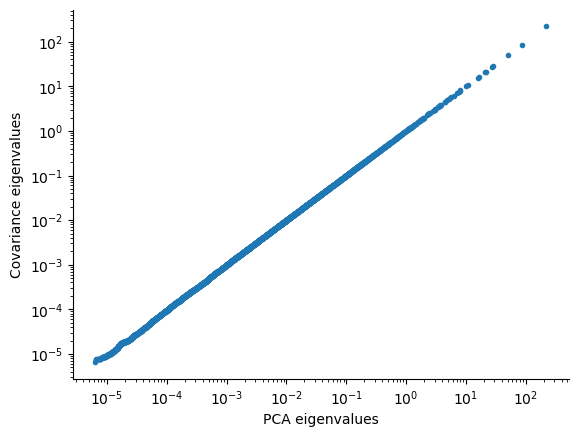

In [ ]:
plt.loglog(eigvals.cpu(), eigvals_cov.cpu(), ".")
plt.xlabel("PCA eigenvalues")
plt.ylabel("Covariance eigenvalues")
plt.show()

In [ ]:
img_shape = train_data.shape[1:]
X_train_tsr = train_data.view(-1, np.prod(img_shape))
X_test_tsr = test_data.view(-1, np.prod(img_shape))

In [ ]:
U, S, V = torch.linalg.svd(X_train_tsr)
# Normalize the singular values
S_normalized = S / torch.sqrt(torch.sum(S**2))

# Compute the principal components
PC = torch.matmul(U, torch.diag(S_normalized))


### Load Image Dataset: CIFAR

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='~/Datasets', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='~/Datasets', train=False, download=True, transform=transform)

# Create a big tensor to store the data
train_data = torch.stack([data for data, _ in trainset], dim=0)
test_data = torch.stack([data for data, _ in testset], dim=0)

# Print the shape of the big tensors
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Files already downloaded and verified
Files already downloaded and verified
Train data shape: torch.Size([50000, 3, 32, 32])
Test data shape: torch.Size([10000, 3, 32, 32])


In [7]:
img_shape = train_data.shape[1:]
X_train_tsr = train_data.view(-1, np.prod(img_shape))
X_test_tsr = test_data.view(-1, np.prod(img_shape))

In [7]:
kmeans = MiniBatchKMeans(n_clusters=100, random_state=0, batch_size=2048, verbose=1)
kmeans.fit(X_train_tsr.numpy())

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Init 1/3 with method k-means++
Inertia for init 1/3: 3302652.25
Init 2/3 with method k-means++
Inertia for init 2/3: 3332946.0
Init 3/3 with method k-means++
Inertia for init 3/3: 3310792.25
[MiniBatchKMeans] Reassigning 11 cluster centers.
Minibatch step 1/2441: mean batch inertia: 533.6673583984375
[MiniBatchKMeans] Reassigning 5 cluster centers.
Minibatch step 2/2441: mean batch inertia: 433.9085693359375, ewa inertia: 433.9085693359375
[MiniBatchKMeans] Reassigning 6 cluster centers.
Minibatch step 3/2441: mean batch inertia: 421.0343322753906, ewa inertia: 432.8539329286657
Minibatch step 4/2441: mean batch inertia: 415.7366638183594, ewa inertia: 431.45171428752224
[MiniBatchKMeans] Reassigning 4 cluster centers.
Minibatch step 5/2441: mean batch inertia: 406.3227844238281, ewa inertia: 429.39319352350367
[MiniBatchKMeans] Reassigning 4 cluster centers.
Minibatch step 6/2441: mean batch inertia: 413.5907287597656, ewa inertia: 428.0986815002987
Minibatch step 7/2441: mean batch i

MiniBatchKMeans(batch_size=2048, n_clusters=100, random_state=0, verbose=1)

In [9]:
kmeans.inertia_

20025618.0

In [20]:
n_clusters = 500
gmm_km_cov, kmeans = kmeans_initialized_gmm(X_train_tsr, n_clusters, 
                        n_rank=None,
                        kmeans_batch=2048, 
                        kmeans_random_seed=0,
                        kmeans_verbose=0,
                        gmm_random_seed=42, 
                        store_device="cpu"
                        lambda_EPS=1E-5, 
                        sigma_max=10)
avg_loss, Nparams = eval_score_model(X_train_tsr, gmm_km_cov, Nbatch=100, 
                        batch_size=16, sigma_max=10, device="cuda")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  17952537.41912062


 81%|████████▏ | 407/500 [01:50<00:28,  3.25it/s]

: 

In [9]:
df_col = []
for n_clusters in [1, 5, 10, 20, 50, 100, ]:#150, 200, 500, 1000]:
    kmeans, eigval_mat, eigvec_mat, freq_vec, center_mat = compute_cluster(X_train_tsr, 
                                n_clusters, lambda_EPS=1E-5, store_device="cpu")
    for n_rank in reversed([8, 16, 32, 64, 96, 128, 192, 256, 374, 512, 1024, 1536, 2048, 2560, None]):
        gmm_km_cov = initialize_gmm_ansatz(eigval_mat, eigvec_mat, freq_vec, center_mat,
                        n_rank=n_rank, sigma_max=10, lambda_EPS=1E-5)
        if n_rank is None:
            n_rank = np.prod(img_shape)
        scaling = 1 if n_clusters <= 20 else n_clusters / 20
        print(f"N components {n_clusters} | N rank {n_rank}")
        eval_loss, Nparams = eval_score_model(X_train_tsr, gmm_km_cov, 
                        Nbatch=int(50 * scaling), batch_size=int(2048 / scaling), device="cuda")
        # print(f"Average loss {eval_loss:.3f} | N params {Nparams}")
        df_col.append({"n_clusters": n_clusters, "n_rank": n_rank, "eval_loss": eval_loss, "Nparams": Nparams})
    
df = pd.DataFrame(df_col)
df.to_csv("CIFAR10_gmm_ansatz_kmeans_loss.csv", index=False)

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  38081515.66691162


100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


cov PCA completed for each cluster.
GMM ansatz model initialized.
N components 1 | N rank 3072


step 49 loss 155.719: 100%|██████████| 50/50 [00:00<00:00, 55.14it/s]


Average loss 153.995  (2048x50 pnts)
Num of parameters 9443329
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 2560


step 49 loss 156.301: 100%|██████████| 50/50 [00:00<00:00, 192.28it/s]


Average loss 153.926  (2048x50 pnts)
Num of parameters 7869953
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 2048


step 49 loss 155.061: 100%|██████████| 50/50 [00:00<00:00, 217.17it/s]


Average loss 153.721  (2048x50 pnts)
Num of parameters 6296577
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 1536


step 49 loss 156.498: 100%|██████████| 50/50 [00:00<00:00, 264.13it/s]


Average loss 154.115  (2048x50 pnts)
Num of parameters 4723201
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 1024


step 49 loss 161.538: 100%|██████████| 50/50 [00:00<00:00, 338.91it/s]


Average loss 157.249  (2048x50 pnts)
Num of parameters 3149825
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 512


step 49 loss 190.961: 100%|██████████| 50/50 [00:00<00:00, 455.57it/s]


Average loss 183.774  (2048x50 pnts)
Num of parameters 1576449
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 374


step 49 loss 221.516: 100%|██████████| 50/50 [00:00<00:00, 500.09it/s]


Average loss 210.292  (2048x50 pnts)
Num of parameters 1152375
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 256


step 49 loss 280.588: 100%|██████████| 50/50 [00:00<00:00, 544.79it/s]


Average loss 255.964  (2048x50 pnts)
Num of parameters 789761
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 192


step 49 loss 358.651: 100%|██████████| 50/50 [00:00<00:00, 559.96it/s]


Average loss 304.993  (2048x50 pnts)
Num of parameters 593089
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 128


step 49 loss 407.338: 100%|██████████| 50/50 [00:00<00:00, 598.31it/s]


Average loss 391.955  (2048x50 pnts)
Num of parameters 396417
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 96


step 49 loss 512.063: 100%|██████████| 50/50 [00:00<00:00, 627.29it/s]


Average loss 466.753  (2048x50 pnts)
Num of parameters 298081
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 64


step 49 loss 677.189: 100%|██████████| 50/50 [00:00<00:00, 642.38it/s]


Average loss 584.743  (2048x50 pnts)
Num of parameters 199745
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 32


step 49 loss 1039.025: 100%|██████████| 50/50 [00:00<00:00, 666.11it/s]


Average loss 836.970  (2048x50 pnts)
Num of parameters 101409
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 16


step 49 loss 1344.274: 100%|██████████| 50/50 [00:00<00:00, 673.12it/s]


Average loss 1167.639  (2048x50 pnts)
Num of parameters 52241
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 1 | N rank 8


step 49 loss 1664.772: 100%|██████████| 50/50 [00:00<00:00, 666.68it/s]


Average loss 1569.969  (2048x50 pnts)
Num of parameters 27657


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  26982009.983399592


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


cov PCA completed for each cluster.
GMM ansatz model initialized.
N components 5 | N rank 3072


step 49 loss 152.451: 100%|██████████| 50/50 [00:01<00:00, 42.17it/s]


Average loss 150.081  (2048x50 pnts)
Num of parameters 47216645
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 2560


step 49 loss 150.918: 100%|██████████| 50/50 [00:01<00:00, 48.61it/s]


Average loss 149.967  (2048x50 pnts)
Num of parameters 39349765
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 2048


step 49 loss 151.398: 100%|██████████| 50/50 [00:00<00:00, 59.14it/s]


Average loss 149.966  (2048x50 pnts)
Num of parameters 31482885
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 1536


step 49 loss 149.487: 100%|██████████| 50/50 [00:00<00:00, 75.55it/s]


Average loss 149.945  (2048x50 pnts)
Num of parameters 23616005
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 1024


step 49 loss 154.256: 100%|██████████| 50/50 [00:00<00:00, 104.70it/s]


Average loss 152.756  (2048x50 pnts)
Num of parameters 15749125
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 512


step 49 loss 177.724: 100%|██████████| 50/50 [00:00<00:00, 171.11it/s]


Average loss 177.313  (2048x50 pnts)
Num of parameters 7882245
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 374


step 49 loss 206.833: 100%|██████████| 50/50 [00:00<00:00, 187.56it/s]


Average loss 201.723  (2048x50 pnts)
Num of parameters 5761875
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 256


step 49 loss 269.093: 100%|██████████| 50/50 [00:00<00:00, 231.59it/s]


Average loss 248.681  (2048x50 pnts)
Num of parameters 3948805
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 192


step 49 loss 325.052: 100%|██████████| 50/50 [00:00<00:00, 245.43it/s]


Average loss 296.049  (2048x50 pnts)
Num of parameters 2965445
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 128


step 49 loss 433.768: 100%|██████████| 50/50 [00:00<00:00, 305.05it/s]


Average loss 384.299  (2048x50 pnts)
Num of parameters 1982085
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 96


step 49 loss 472.166: 100%|██████████| 50/50 [00:00<00:00, 316.03it/s]


Average loss 455.152  (2048x50 pnts)
Num of parameters 1490405
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 64


step 49 loss 614.375: 100%|██████████| 50/50 [00:00<00:00, 328.03it/s]


Average loss 582.085  (2048x50 pnts)
Num of parameters 998725
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 32


step 49 loss 798.536: 100%|██████████| 50/50 [00:00<00:00, 340.65it/s] 


Average loss 800.343  (2048x50 pnts)
Num of parameters 507045
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 16


step 49 loss 1232.884: 100%|██████████| 50/50 [00:00<00:00, 347.61it/s]


Average loss 1104.363  (2048x50 pnts)
Num of parameters 261205
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 5 | N rank 8


step 49 loss 1512.168: 100%|██████████| 50/50 [00:00<00:00, 347.77it/s]


Average loss 1476.242  (2048x50 pnts)
Num of parameters 138285


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  24525138.34275133


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


cov PCA completed for each cluster.
GMM ansatz model initialized.
N components 10 | N rank 3072


step 49 loss 148.505: 100%|██████████| 50/50 [00:02<00:00, 21.65it/s]


Average loss 146.978  (2048x50 pnts)
Num of parameters 94433290
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 2560


step 49 loss 147.173: 100%|██████████| 50/50 [00:01<00:00, 25.10it/s]


Average loss 146.531  (2048x50 pnts)
Num of parameters 78699530
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 2048


step 49 loss 147.103: 100%|██████████| 50/50 [00:01<00:00, 30.74it/s]


Average loss 146.920  (2048x50 pnts)
Num of parameters 62965770
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 1536


step 49 loss 147.637: 100%|██████████| 50/50 [00:01<00:00, 39.66it/s]


Average loss 147.250  (2048x50 pnts)
Num of parameters 47232010
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 1024


step 49 loss 151.979: 100%|██████████| 50/50 [00:00<00:00, 55.93it/s]


Average loss 149.100  (2048x50 pnts)
Num of parameters 31498250
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 512


step 49 loss 175.824: 100%|██████████| 50/50 [00:00<00:00, 94.92it/s]


Average loss 170.534  (2048x50 pnts)
Num of parameters 15764490
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 374


step 49 loss 204.827: 100%|██████████| 50/50 [00:00<00:00, 111.94it/s]


Average loss 195.586  (2048x50 pnts)
Num of parameters 11523750
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 256


step 49 loss 257.273: 100%|██████████| 50/50 [00:00<00:00, 146.25it/s]


Average loss 239.107  (2048x50 pnts)
Num of parameters 7897610
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 192


step 49 loss 319.507: 100%|██████████| 50/50 [00:00<00:00, 157.42it/s]


Average loss 287.721  (2048x50 pnts)
Num of parameters 5930890
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 128


step 49 loss 371.069: 100%|██████████| 50/50 [00:00<00:00, 188.34it/s]


Average loss 368.332  (2048x50 pnts)
Num of parameters 3964170
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 96


step 49 loss 505.272: 100%|██████████| 50/50 [00:00<00:00, 196.72it/s]


Average loss 444.560  (2048x50 pnts)
Num of parameters 2980810
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 64


step 49 loss 623.385: 100%|██████████| 50/50 [00:00<00:00, 206.13it/s]


Average loss 551.108  (2048x50 pnts)
Num of parameters 1997450
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 32


step 49 loss 817.778: 100%|██████████| 50/50 [00:00<00:00, 216.46it/s]


Average loss 798.481  (2048x50 pnts)
Num of parameters 1014090
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 16


step 49 loss 1171.182: 100%|██████████| 50/50 [00:00<00:00, 222.17it/s]


Average loss 1069.715  (2048x50 pnts)
Num of parameters 522410
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 10 | N rank 8


step 49 loss 1551.565: 100%|██████████| 50/50 [00:00<00:00, 222.83it/s]


Average loss 1426.082  (2048x50 pnts)
Num of parameters 276570


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  22799693.69737351


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


cov PCA completed for each cluster.
GMM ansatz model initialized.
N components 20 | N rank 3072


step 49 loss 139.930: 100%|██████████| 50/50 [00:04<00:00, 11.16it/s]


Average loss 140.408  (2048x50 pnts)
Num of parameters 188866580
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 2560


step 49 loss 141.372: 100%|██████████| 50/50 [00:03<00:00, 12.74it/s]


Average loss 140.300  (2048x50 pnts)
Num of parameters 157399060
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 2048


step 49 loss 141.030: 100%|██████████| 50/50 [00:03<00:00, 15.65it/s]


Average loss 140.228  (2048x50 pnts)
Num of parameters 125931540
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 1536


step 49 loss 140.869: 100%|██████████| 50/50 [00:02<00:00, 20.33it/s]


Average loss 140.449  (2048x50 pnts)
Num of parameters 94464020
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 1024


step 49 loss 142.149: 100%|██████████| 50/50 [00:01<00:00, 28.90it/s]


Average loss 141.685  (2048x50 pnts)
Num of parameters 62996500
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 512


step 49 loss 164.322: 100%|██████████| 50/50 [00:00<00:00, 50.26it/s]


Average loss 160.179  (2048x50 pnts)
Num of parameters 31528980
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 374


step 49 loss 181.937: 100%|██████████| 50/50 [00:00<00:00, 62.12it/s]


Average loss 182.236  (2048x50 pnts)
Num of parameters 23047500
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 256


step 49 loss 231.095: 100%|██████████| 50/50 [00:00<00:00, 79.65it/s]


Average loss 224.658  (2048x50 pnts)
Num of parameters 15795220
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 192


step 49 loss 314.961: 100%|██████████| 50/50 [00:00<00:00, 86.42it/s]


Average loss 271.403  (2048x50 pnts)
Num of parameters 11861780
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 128


step 49 loss 383.616: 100%|██████████| 50/50 [00:00<00:00, 112.89it/s]


Average loss 354.230  (2048x50 pnts)
Num of parameters 7928340
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 96


step 49 loss 443.050: 100%|██████████| 50/50 [00:00<00:00, 119.10it/s]


Average loss 432.729  (2048x50 pnts)
Num of parameters 5961620
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 64


step 49 loss 528.542: 100%|██████████| 50/50 [00:00<00:00, 126.30it/s]


Average loss 530.546  (2048x50 pnts)
Num of parameters 3994900
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 32


step 49 loss 893.973: 100%|██████████| 50/50 [00:00<00:00, 134.00it/s] 


Average loss 778.219  (2048x50 pnts)
Num of parameters 2028180
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 16


step 49 loss 1116.610: 100%|██████████| 50/50 [00:00<00:00, 138.26it/s]


Average loss 1054.932  (2048x50 pnts)
Num of parameters 1044820
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 20 | N rank 8


step 49 loss 1514.063: 100%|██████████| 50/50 [00:00<00:00, 138.78it/s]


Average loss 1394.072  (2048x50 pnts)
Num of parameters 553140


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  21174666.09534799


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


cov PCA completed for each cluster.
GMM ansatz model initialized.
N components 50 | N rank 3072


step 124 loss 123.559: 100%|██████████| 125/125 [00:12<00:00, 10.38it/s]


Average loss 125.153  (819x125 pnts)
Num of parameters 472166450
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 2560


step 124 loss 124.919: 100%|██████████| 125/125 [00:10<00:00, 11.93it/s]


Average loss 125.131  (819x125 pnts)
Num of parameters 393497650
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 2048


step 124 loss 124.056: 100%|██████████| 125/125 [00:08<00:00, 14.67it/s]


Average loss 125.080  (819x125 pnts)
Num of parameters 314828850
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 1536


step 124 loss 123.642: 100%|██████████| 125/125 [00:06<00:00, 19.12it/s]


Average loss 125.072  (819x125 pnts)
Num of parameters 236160050
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 1024


step 124 loss 124.318: 100%|██████████| 125/125 [00:04<00:00, 27.39it/s]


Average loss 125.456  (819x125 pnts)
Num of parameters 157491250
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 512


step 124 loss 140.997: 100%|██████████| 125/125 [00:02<00:00, 48.28it/s]


Average loss 134.537  (819x125 pnts)
Num of parameters 78822450
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 374


step 124 loss 161.165: 100%|██████████| 125/125 [00:02<00:00, 59.55it/s]


Average loss 151.381  (819x125 pnts)
Num of parameters 57618750
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 256


step 124 loss 213.942: 100%|██████████| 125/125 [00:01<00:00, 76.41it/s]


Average loss 189.052  (819x125 pnts)
Num of parameters 39488050
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 192


step 124 loss 299.046: 100%|██████████| 125/125 [00:01<00:00, 83.15it/s]


Average loss 232.554  (819x125 pnts)
Num of parameters 29654450
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 128


step 124 loss 400.296: 100%|██████████| 125/125 [00:01<00:00, 108.18it/s]


Average loss 316.644  (819x125 pnts)
Num of parameters 19820850
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 96


step 124 loss 499.103: 100%|██████████| 125/125 [00:01<00:00, 114.23it/s]


Average loss 397.775  (819x125 pnts)
Num of parameters 14904050
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 64


step 124 loss 704.296: 100%|██████████| 125/125 [00:01<00:00, 121.15it/s]


Average loss 505.983  (819x125 pnts)
Num of parameters 9987250
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 32


step 124 loss 975.040: 100%|██████████| 125/125 [00:00<00:00, 128.94it/s] 


Average loss 753.956  (819x125 pnts)
Num of parameters 5070450
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 16


step 124 loss 1562.304: 100%|██████████| 125/125 [00:00<00:00, 133.27it/s]


Average loss 1032.328  (819x125 pnts)
Num of parameters 2612050
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 50 | N rank 8


step 124 loss 1924.172: 100%|██████████| 125/125 [00:00<00:00, 134.24it/s]


Average loss 1354.254  (819x125 pnts)
Num of parameters 1382850


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  20025639.778728113


100%|██████████| 100/100 [00:30<00:00,  3.30it/s]


cov PCA completed for each cluster.
GMM ansatz model initialized.
N components 100 | N rank 3072


step 249 loss 105.938: 100%|██████████| 250/250 [00:27<00:00,  9.18it/s]


Average loss 108.352  (409x250 pnts)
Num of parameters 944332900
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 2560


step 249 loss 107.963: 100%|██████████| 250/250 [00:23<00:00, 10.57it/s]


Average loss 108.416  (409x250 pnts)
Num of parameters 786995300
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 2048


step 249 loss 107.957: 100%|██████████| 250/250 [00:19<00:00, 13.02it/s]


Average loss 108.251  (409x250 pnts)
Num of parameters 629657700
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 1536


step 249 loss 105.940: 100%|██████████| 250/250 [00:14<00:00, 16.99it/s]


Average loss 108.249  (409x250 pnts)
Num of parameters 472320100
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 1024


step 249 loss 107.528: 100%|██████████| 250/250 [00:10<00:00, 24.47it/s]


Average loss 108.718  (409x250 pnts)
Num of parameters 314982500
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 512


step 249 loss 108.131: 100%|██████████| 250/250 [00:05<00:00, 43.66it/s]


Average loss 111.337  (409x250 pnts)
Num of parameters 157644900
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 374


step 249 loss 119.208: 100%|██████████| 250/250 [00:04<00:00, 53.58it/s]


Average loss 119.714  (409x250 pnts)
Num of parameters 115237500
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 256


step 249 loss 148.646: 100%|██████████| 250/250 [00:03<00:00, 70.54it/s]


Average loss 148.318  (409x250 pnts)
Num of parameters 78976100
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 192


step 249 loss 180.720: 100%|██████████| 250/250 [00:03<00:00, 76.82it/s]


Average loss 187.434  (409x250 pnts)
Num of parameters 59308900
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 128


step 249 loss 293.987: 100%|██████████| 250/250 [00:02<00:00, 104.94it/s]


Average loss 267.215  (409x250 pnts)
Num of parameters 39641700
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 96


step 249 loss 334.197: 100%|██████████| 250/250 [00:02<00:00, 111.24it/s]


Average loss 343.364  (409x250 pnts)
Num of parameters 29808100
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 64


step 249 loss 480.027: 100%|██████████| 250/250 [00:02<00:00, 118.79it/s]


Average loss 467.094  (409x250 pnts)
Num of parameters 19974500
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 32


step 249 loss 861.563: 100%|██████████| 250/250 [00:01<00:00, 127.25it/s] 


Average loss 730.903  (409x250 pnts)
Num of parameters 10140900
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 16


step 249 loss 1026.794: 100%|██████████| 250/250 [00:01<00:00, 132.18it/s]


Average loss 1022.145  (409x250 pnts)
Num of parameters 5224100
Low rank GMM ansatz
GMM low rank ansatz model initialized.
N components 100 | N rank 8


step 249 loss 1729.411: 100%|██████████| 250/250 [00:01<00:00, 133.78it/s]


Average loss 1326.707  (409x250 pnts)
Num of parameters 2765700


In [9]:
n_clusters = 200
kmeans, eigval_mat, eigvec_mat, freq_vec, center_mat = compute_cluster(X_train_tsr, 
                                n_clusters, lambda_EPS=1E-5, store_device="cpu")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  18964315.7809179


100%|██████████| 200/200 [00:55<00:00,  3.61it/s]


cov PCA completed for each cluster.


In [11]:
n_rank = 512
gmm_km_cov = initialize_gmm_ansatz(eigval_mat, eigvec_mat, freq_vec, center_mat,
                n_rank=n_rank, sigma_max=10, lambda_EPS=1E-5)
if n_rank is None:
    n_rank = np.prod(img_shape)
scaling = 1 if n_clusters <= 20 else n_clusters / 20
print(f"N components {n_clusters} | N rank {n_rank}")
eval_loss, Nparams = eval_score_model(X_train_tsr, gmm_km_cov, 
                Nbatch=int(50 * scaling), batch_size=int(2048 / scaling), device="cuda")

Low rank GMM ansatz


: 

In [9]:
df_col = []
for n_clusters in [150, 200, 500, ]:#, 1000]:
    kmeans, eigval_mat, eigvec_mat, freq_vec, center_mat = compute_cluster(X_train_tsr, 
                                n_clusters, lambda_EPS=1E-5, store_device="cpu")
    for n_rank in reversed([8, 16, 32, 64, 96, 128, 192, 256, 374, 512, ]): #1024, 1536, 2048,
        if n_clusters == 500 and n_rank > 1024:
            continue
        gmm_km_cov = initialize_gmm_ansatz(eigval_mat, eigvec_mat, freq_vec, center_mat,
                        n_rank=n_rank, sigma_max=10, lambda_EPS=1E-5)
        if n_rank is None:
            n_rank = np.prod(img_shape)
        scaling = 1 if n_clusters <= 20 else n_clusters / 20
        print(f"N components {n_clusters} | N rank {n_rank}")
        eval_loss, Nparams = eval_score_model(X_train_tsr, gmm_km_cov, 
                        Nbatch=int(50 * scaling), batch_size=int(2048 / scaling), device="cpu")
        # print(f"Average loss {eval_loss:.3f} | N params {Nparams}")
        df_col.append({"n_clusters": n_clusters, "n_rank": n_rank, "eval_loss": eval_loss, "Nparams": Nparams})
    
df = pd.DataFrame(df_col)
df.to_csv("CIFAR10_gmm_ansatz_kmeans_loss_high.csv", index=False)

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  19431122.972374268


100%|██████████| 150/150 [00:44<00:00,  3.35it/s]


: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


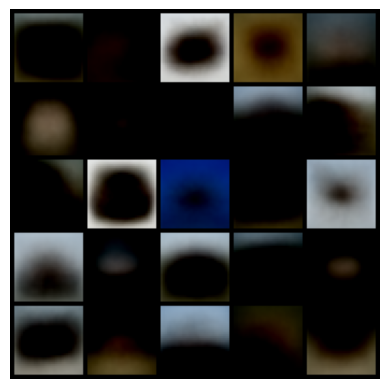

In [16]:
# visualize the cluster centers
centroids = kmeans.cluster_centers_.reshape(-1, *img_shape)
mtg = make_grid(torch.from_numpy(centroids), nrow=5)
plt.imshow(mtg.permute(1, 2, 0) )
plt.axis("off")
plt.show()

### Load Image Dataset: MNIST

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=50, random_state=0, batch_size=2048, verbose=1).fit(Xtrain_norm)

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Init 1/3 with method k-means++
Inertia for init 1/3: 3131484.747459087
Init 2/3 with method k-means++
Inertia for init 2/3: 3151060.893490196
Init 3/3 with method k-means++
Inertia for init 3/3: 3218909.1866551344
Minibatch step 1/2929: mean batch inertia: 504.90554638370367
Minibatch step 2/2929: mean batch inertia: 348.0095235243042, ewa inertia: 348.0095235243042
Minibatch step 3/2929: mean batch inertia: 338.5212960954484, ewa inertia: 347.36180466047534
Minibatch step 4/2929: mean batch inertia: 337.1054708362559, ewa inertia: 346.6616506073095
Minibatch step 5/2929: mean batch inertia: 331.9809149992216, ewa inertia: 345.6594624262671
Minibatch step 6/2929: mean batch inertia: 334.13124232955556, ewa inertia: 344.87248238399894
Minibatch step 7/2929: mean batch inertia: 329.6379605159852, ewa inertia: 343.8324896910208
Minibatch step 8/2929: mean batch inertia: 330.6879780063477, ewa inertia: 342.9351726486312
Minibatch step 9/2929: mean batch inertia: 332.7818541079047, ewa iner

In [ ]:
kmeans.cluster_centers_.shape

(50, 784)

In [ ]:
# estimate covariance matrix of each cluster
covmats = []
eigval_col = []
eigvec_col = []
for i in range(50):
    print(i, "number of samples", np.sum(kmeans.labels_ == i))
    covmat = torch.tensor(np.cov(Xtrain_norm[kmeans.labels_ == i].T))
    # PCA to reduce dimension
    eigval, eigvec = torch.linalg.eigh(covmat.to(torch.float64))
    eigval = eigval.flip(dims=(0,))  # sort from largest to smallest
    eigvec = eigvec.flip(dims=(1,))  # sort from largest to smallest
    eigval_col.append(eigval)
    eigvec_col.append(eigvec)
    covmats.append(covmat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


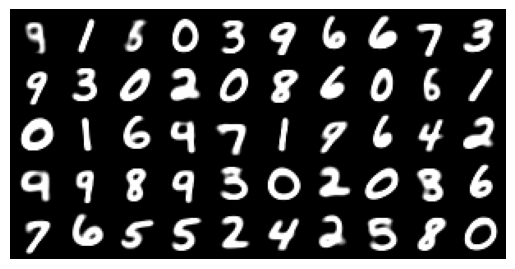

In [ ]:
# visualize the cluster centers
centroids = kmeans.cluster_centers_.reshape(-1, 1, 28, 28)
mtg = make_grid(torch.from_numpy(centroids), nrow=10)
plt.imshow(mtg.permute(1, 2, 0) )
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 151.5, 151.5, -0.5)

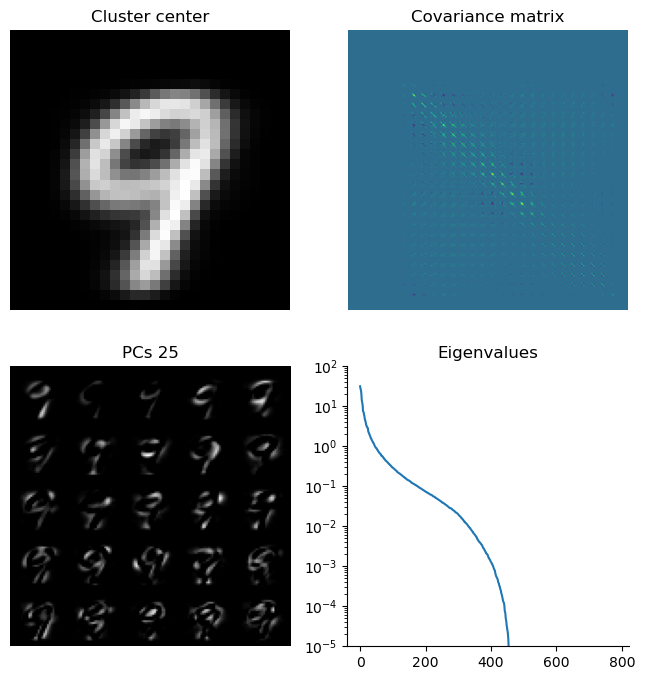

In [ ]:
# visualize the covariance matrix & PC
cid = 5
nPC = 25
fig, axs = plt.subplots(2, 2, figsize=[8, 8])
axs[0,0].imshow(kmeans.cluster_centers_[cid].reshape(28, 28), cmap="gray")
axs[0,0].set_title("Cluster center")
axs[0,0].axis("off")
axs[0,1].imshow(covmats[cid])
axs[0,1].set_title("Covariance matrix")
axs[0,1].axis("off")
axs[1,1].semilogy(eigval_col[cid])
axs[1,1].set_ylim(1E-5, 1E2)
axs[1,1].set_title("Eigenvalues")
nrow = int(np.sqrt(nPC))
mtg = make_grid(eigvec_col[cid].reshape(1, 28, 28, -1).permute(3,0,1,2)[:nPC], nrow=nrow)
axs[1,0].imshow(mtg.permute(1, 2, 0) / mtg.max())
# axs[3].imshow(eigvec_col[cid].reshape(28, 28, -1)[:, :, 0], cmap="gray")
axs[1,0].set_title(f"PCs {nPC}")
axs[1,0].axis("off")

In [ ]:
innerprod = eigvec_col[0] @ eigvec_col[2].T
plt.imshow(innerprod.detach().cpu())
plt.colorbar()
plt.show()

In [ ]:
ndim = Xtrain.shape[1]
gmm_components = 50
sigma_max = 10
batch_size = 2048
torch.manual_seed(42)
score_model_gmm_kmean = GMM_ansatz_net(ndim=ndim,
             n_components=gmm_components, sigma=sigma_max)
# Data PC initialization
score_model_gmm_kmean.logLambdas.data = logLamda_init[None, :].repeat(gmm_components, 1)
score_model_gmm_kmean.Us.data = U_init[None, :, :].repeat(gmm_components, 1, 1)
score_model_gmm_kmean.mus.data = torch.from_numpy(kmeans.cluster_centers_).float()

In [ ]:
score_model_gmm_kmean.Us.shape

torch.Size([50, 784, 784])

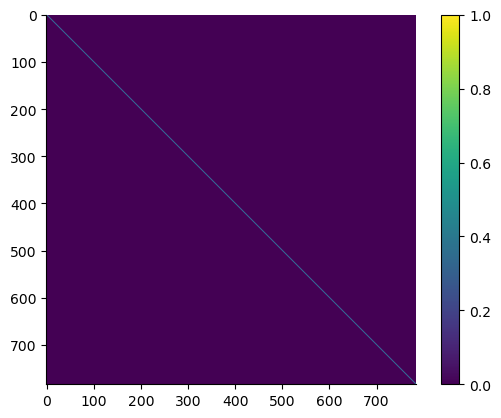

In [ ]:
innerprod = score_model_gmm_kmean.Us[0] @ score_model_gmm_kmean.Us[0].T
plt.imshow(innerprod.detach().cpu())
plt.colorbar()
plt.show()


In [ ]:
print("U weight norm",score_model_gmm_kmean.Us[0].norm().item())
print("U grad norm", score_model_gmm_kmean.Us.grad[0].norm().item())
print("U grad / weight ratio", score_model_gmm_kmean.Us.grad[0].norm().item() / score_model_gmm_kmean.Us[0].norm().item())
print("Lambda weight norm",score_model_gmm_kmean.logLambdas.norm().item())
print("Lambda grad norm", score_model_gmm_kmean.logLambdas.grad.norm().item())
print ("Lambda grad / weight ratio", score_model_gmm_kmean.logLambdas.grad.norm().item() / score_model_gmm_kmean.logLambdas.norm().item())
print("mu weight norm",score_model_gmm_kmean.mus.norm().item())
print("mu grad norm", score_model_gmm_kmean.mus.grad.norm().item())
print("mu grad / weight ratio", score_model_gmm_kmean.mus.grad.norm().item() / score_model_gmm_kmean.mus.norm().item())
print("pi weight norm",score_model_gmm_kmean.logweights.norm().item())
print("pi grad norm", score_model_gmm_kmean.logweights.grad.norm().item())
print("pi grad / weight ratio", score_model_gmm_kmean.logweights.grad.norm().item() / score_model_gmm_kmean.logweights.norm().item())

U weight norm 29.555498123168945
U grad norm 6.807952672716056e-07
U grad / weight ratio 2.303447109686577e-08
Lambda weight norm 1131.917236328125
Lambda grad norm 0.13710720837116241
Lambda grad / weight ratio 0.00012112829805112818
mu weight norm 155.2152557373047
mu grad norm 1.1955679655075073
mu grad / weight ratio 0.0077026446906156955
pi weight norm 27.922592163085938
pi grad norm 9.486411727266386e-05
pi grad / weight ratio 3.397396513855027e-06


### GMM initialize with correct Kmeans center + covariance

Note that GMM is not a very bad model of images, good parameters of GMM exist (i.e. parameters estimated by Kmeans / EM). 

* 50 full Gaussian GMM with Kmeans mean + cov initialization => 72 loss
* 100 full Gaussian GMM with Kmeans mean + cov initialization => 64 loss
* 200 full Gaussian GMM with Kmeans mean + cov initialization => 56.22 loss 

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans
# kmeans = KMeans(n_clusters=50, random_state=0).fit(Xtrain_norm)
kmeans = MiniBatchKMeans(n_clusters=100, random_state=0, batch_size=2048, verbose=1).fit(Xtrain_norm)

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Init 1/3 with method k-means++
Inertia for init 1/3: 2813040.8667306923
Init 2/3 with method k-means++
Inertia for init 2/3: 2813712.3577361796
Init 3/3 with method k-means++
Inertia for init 3/3: 2788756.1150021544
Minibatch step 1/2929: mean batch inertia: 459.7645289666375
Minibatch step 2/2929: mean batch inertia: 320.2766292197611, ewa inertia: 320.2766292197611
Minibatch step 3/2929: mean batch inertia: 312.3704697593438, ewa inertia: 319.7369110625659
Minibatch step 4/2929: mean batch inertia: 306.3488045746614, ewa inertia: 318.8229648920945
Minibatch step 5/2929: mean batch inertia: 306.39338884997636, ewa inertia: 317.9744533094789
Minibatch step 6/2929: mean batch inertia: 300.9985250171531, ewa inertia: 316.81558258590155
Minibatch step 7/2929: mean batch inertia: 302.02446171700257, ewa inertia: 315.8058588966462
Minibatch step 8/2929: mean batch inertia: 304.3405165998743, ewa inertia: 315.0231712406475
Minibatch step 9/2929: mean batch inertia: 299.555517826682, ewa iner

In [ ]:
covmats = []
eigval_col = []
eigvec_col = []
freq_col = []
for i in trange(kmeans.n_clusters):
    n_samples = np.sum(kmeans.labels_ == i)
    # print(i, "number of samples", n_samples)
    freq_col.append(n_samples)
    covmat = torch.tensor(np.cov(Xtrain_norm[kmeans.labels_ == i].T))
    # PCA to reduce dimension
    eigval, eigvec = torch.linalg.eigh(covmat.to(torch.float64).cuda())
    eigval = eigval.flip(dims=(0,))  # sort from largest to smallest
    eigvec = eigvec.flip(dims=(1,))  # sort from largest to smallest
    eigval_col.append(eigval)
    eigvec_col.append(eigvec)
    covmats.append(covmat)
eigval_mat = torch.stack(eigval_col, dim=0)
eigvec_mat = torch.stack(eigvec_col, dim=0)
freq_vec = torch.tensor(freq_col)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
ndim = Xtrain.shape[1]
gmm_components = 100
sigma_max = 10
batch_size = 2048
torch.manual_seed(42)
score_model_gmm_km_cov = GMM_ansatz_net(ndim=ndim,
             n_components=gmm_components, sigma=sigma_max)
# Data PC initialization
# score_model_gmm_km_cov.logLambdas.data = logLamda_init[None, :].repeat(gmm_components, 1)
score_model_gmm_km_cov.logLambdas.data = torch.log(eigval_mat + 1E-5).float()
# score_model_gmm_km_cov.Us.data = U_init[None, :, :].repeat(gmm_components, 1, 1)
score_model_gmm_km_cov.Us.data = eigvec_mat.float()
score_model_gmm_km_cov.mus.data = torch.from_numpy(kmeans.cluster_centers_).float()
score_model_gmm_km_cov.logweights.data = torch.log(freq_vec / freq_vec.sum())

In [ ]:

df = pd.DataFrame(df_col)

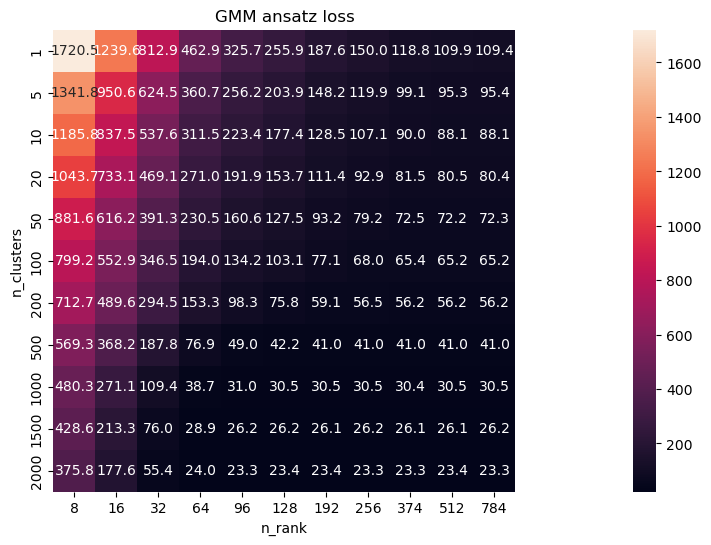

In [ ]:
import seaborn as sns
plt.figure(figsize=[10,6])
sns.heatmap(df.pivot_table(index="n_clusters", columns="n_rank", values="eval_loss"), annot=True, fmt=".1f")
plt.axis("image")
plt.title("GMM ansatz loss")
plt.show()

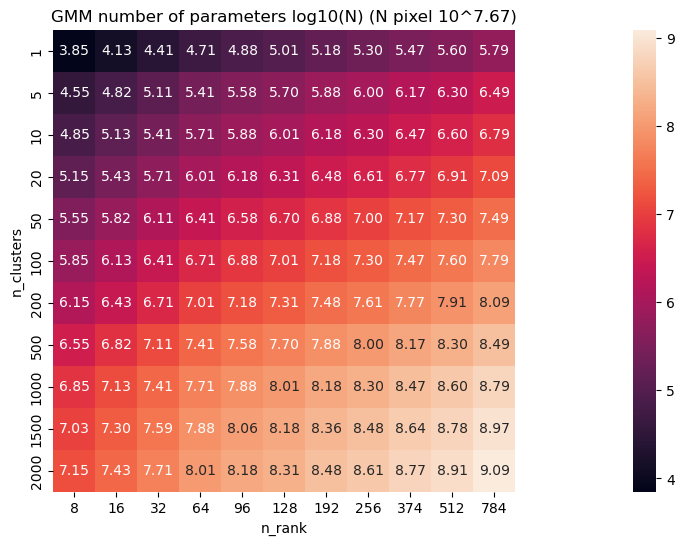

In [ ]:
import seaborn as sns
plt.figure(figsize=[10,6])
sns.heatmap(df.pivot_table(index="n_clusters", columns="n_rank", values="Nparams").apply(np.log10), annot=True, fmt=".2f")
plt.axis("image")
Npixel = 28 * 28 * 60000
plt.title(f"GMM number of parameters log10(N) (N pixel 10^{np.log10(Npixel):.2f})")
plt.show()